# Haar Wavelet

In [1]:
import numpy as np
import utils
from typing import Union
from skimage.transform import resize

In [2]:
class Load_Image:
    def __init__(self, image_or_path: Union[np.ndarray, str]) -> None:
        if isinstance(image_or_path, np.ndarray):
            self.image = image_or_path
        elif isinstance(image_or_path, str):
            self.image = utils.load_image(image_or_path)
        else:
            raise TypeError("Invalid type : image_or_path")
        
        try:
            self.image_grayscaled = utils.grayscaling(self.image)
        except AssertionError:
            self.image_grayscaled = self.image
    
    def imshow(self, original: bool = True):
        if original:
            utils.imshow(self.image, "Original image", False)
        else:
            utils.imshow(self.image_grayscaled, "Grayscaled image", True)
    
    def pad(self,size: tuple):
        #only pads grayscaled image
        #used to pad with zeros (0) so that the image size is a power of 2 #size : (row, col)
        row, col = self.image_grayscaled.shape
        assert row <= size[0] and col <= size[1], "Invalid size : size must be larger than the original image"
        row_pad = size[0] - row
        col_pad = size[1] - col
        self.image_grayscaled = np.pad(self.image_grayscaled, ((0,row_pad),(0,col_pad)), 'constant', constant_values=0)


(3598, 5397, 3)
(4096, 8192)


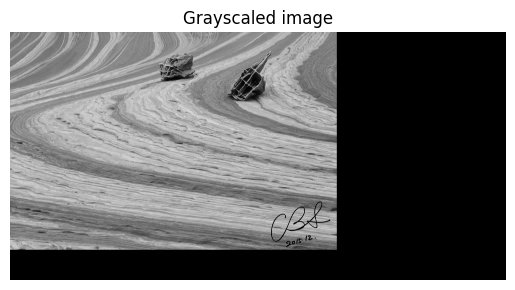

In [3]:
a = Load_Image("./Boneyard_IMG_5341.jpg")
a.pad((4096, 8192))
print(a.image.shape)

print(a.image_grayscaled.shape) #does not resize this!
a.imshow(False)


### Haar wavelet construction : use the equation below taught during class
**주의** 
밑의 n은 $2**n$할때 그 n이다. 따라서 밑의 n과는 다르다! (`get_haar_mat`에서 그래서 log취해서 함)

<img src="IMG_E49B43BAD0E8-1.jpeg" alt="Alt text" width="600" height="500">


<img src="image.png" alt="Alt text" width="450" height="200">
<img src="image-1.png" alt="Alt text" width="600" height="400">

Eqations USed
$W_n = (W_{n-1}\otimes )$

In [44]:
class HaarTransform(Load_Image):
    def __init__(self, image_or_path: Union[np.ndarray, str]) -> None:
        super().__init__(image_or_path)

    def n_to_size(self, n: int) -> int:
        return 2 ** n

    def create_zero_vector(self,n, i, value):
        """
        creates an (almost) zero vector of size n, with value at index i
        """
        vector = np.zeros(n)
        vector[i] = value
        return vector
    
    def D_n(self, size:int, n:int) -> np.ndarray :
        """
        for normalizing the haar matrix
        * size : size of the vector
        * n : n in the equation (log_2 thing)
        """
        size_log = int(np.log2(size))
        if n == 0 :
            return self.create_zero_vector(size, 0, 2**(-size_log/2)).reshape(1,size)
        else : 
            how_many = int(2**(n-1))
            left_mat = self.D_n(size, n-1)
            right_mat = np.array([self.create_zero_vector(size, x , 2**(-(size_log-(n-1))/2)) for x in range(how_many,how_many+how_many)])
            return np.concatenate((left_mat, right_mat), axis = 0)

    def get_haar_mat(self,size: int) -> np.ndarray: #! put in normalize! (with D) 
        # only allow n of power of 2 and n > 0 (check with bitwise and operator)
        assert size & (size - 1) == 0 and size >= 0, "n must be a zero or positive power of 2"
        #get n in the equation (cause 2^n = size)
        n = int(np.log2(size))

        # base case
        if n == 0:
            return np.array([[1]])
        else : 
            # recursive case, use np.kron to get kronecker product
            left_mat = np.kron(self.get_haar_mat(self.n_to_size(n - 1)), np.array([[1], [1]])) #reason for [[1],[-1]] : to make it explicilty into column vector
            right_mat = np.kron(np.eye(self.n_to_size(n - 1)), np.array([[1], [-1]]))
            return np.concatenate((left_mat, right_mat), axis = 1) 
    
    def normalize(self, haar_mat: np.ndarray) -> np.ndarray:
        W_n = haar_mat
        size = W_n.shape[0]
        n = int(np.log2(size))
        H_n = W_n@self.D_n(size, n)
        return H_n
    
    def haar_transform_2d(self, size: tuple, img : np.ndarray) -> np.ndarray:
        x_size, y_size = size
        normalized_haar_mat_x = self.normalize(self.get_haar_mat(x_size))
        normalized_haar_mat_y = self.normalize(self.get_haar_mat(y_size))
        transformed_2d = (normalized_haar_mat_x.T)@img@normalized_haar_mat_y
        return transformed_2d

    def compress_matrix(self, percentage, matrix : np.ndarray, take_abs = True) -> np.ndarray:
        """ 
        compresses the matrix by setting the values below percentage to 0
        * percentage : percentage of the values to keep
        * matrix : matrix to compress (expected to be haar transformed matrix)
        * take_abs : whether compress based on absolute value or remove FROM negative values (i.e. |mask| > threshold or mask > threshold)
        """
        size = matrix.shape
        x_size, y_size = size
        if take_abs:
            threshold = np.percentile(np.abs(matrix), percentage)
            mask = np.abs(matrix) > threshold
        else : 
            threshold = np.percentile(matrix, percentage)
            mask = matrix > threshold
        matrix_compressed = matrix * mask       
        return matrix_compressed
    
    def compress_freq(self):
        print("DO THIS DO TYHIS")
        raise NotImplementedError("DO THIS DO TYHIS")
        #! DO THIS!

    def inverse_haar_transform_2d(self, size: tuple, img_trans : np.ndarray, to_unit8 = True) -> np.ndarray:
        """ 
        inverse haar transform
        * size : size of the image (transformed haar matrix)
        * img_trans : transformed image (after haar transform)
        * to_unit8 : whether to convert to unit8 (for displaying purposes)
        """
        x_size, y_size = size
        normalized_haar_mat_x = self.normalize(self.get_haar_mat(x_size))
        normalized_haar_mat_y = self.normalize(self.get_haar_mat(y_size))
        transformed_2d = (normalized_haar_mat_x)@img_trans@(normalized_haar_mat_y.T)
        return transformed_2d.astype(np.uint8) if to_unit8 else transformed_2d
    

    def compress_partial_enc_dec(self, img):
        """
        * compress image by halving thing
        """
        x_size, y_size = img.shape
        x_bound, y_bound = x_size//2, y_size//2
        normalized_haar_mat_x = self.normalize(self.get_haar_mat(x_size))
        normalized_haar_mat_y = self.normalize(self.get_haar_mat(y_size))

        #get partial haar matricies 
        HX_L = normalized_haar_mat_x[:, :x_bound]
        HX_H = normalized_haar_mat_x[:, x_bound: ]
        HY_L = normalized_haar_mat_y[:, :y_bound]
        HY_H = normalized_haar_mat_y[:, y_bound: ]
        print(HX_L.shape, HX_H.shape, HY_L.shape, HY_H.shape)

        #transform through partial haar matricies
        img_transformed_LL = (HX_L.T)@img@(HY_L)
        img_transformed_LH = (HX_H.T)@img@(HY_L)
        img_transformed_HL = (HX_L.T)@img@(HY_H)
        img_transformed_HH = (HX_H.T)@img@(HY_H)
        print(img_transformed_LL.shape, img_transformed_LH.shape, img_transformed_HL.shape, img_transformed_HH.shape)

        #reconstruct partial transformed images
        img_LL = (HX_L)@img_transformed_LL@(HY_L.T)
        img_LH = (HX_H)@img_transformed_LH@(HY_L.T)
        img_HL = (HX_L)@img_transformed_HL@(HY_H.T)
        img_HH = (HX_H)@img_transformed_HH@(HY_H.T)
        print(img_LL.shape, img_LH.shape, img_HL.shape, img_HH.shape)

        return img_LL, img_LH, img_HL, img_HH


def crop_out_padded_part(img):
    return img
    #return img[0:3598, 0:5397]

# compression using iterated partial haar matricies 

In [5]:
haar = HaarTransform("./Boneyard_IMG_5341.jpg")
power_2_shape = (4096, 8192)
haar.pad(power_2_shape)
padded_image = haar.image_grayscaled

img_LL, img_LH, img_HL, img_HH = haar.compress_partial_enc_dec(padded_image)

(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)


밑에서 주의 : LH, HL, HH을 plotting할대는 30을 곱해줌 (값 range가 너무 작아서, 그냥 일반값을 plotting하면 아무것도 안보임)

In [6]:
def rescale(img):
    #img = img*(np.abs(img)>1.0)
    print(img.min(), img.max())
    img = img*(img>0.0)
    #img = img *(np.abs(img)>0.0)
    return (img - img.min())/(img.max() - img.min()) * 255
plt.imshow(rescale(img_LL), cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(30*rescale(img_LH), cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(30*rescale(img_HL), cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(30*rescale(img_HH), cmap = "gray", vmin = 0, vmax = 255)
plt.show()


NameError: name 'plt' is not defined

(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
-5.927651985475802e-13 235.5


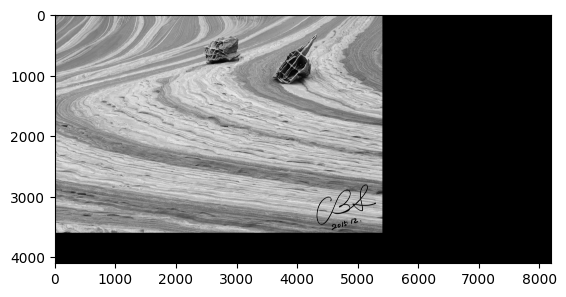

-1.0048484357829787e-14 1.0048484357829787e-14


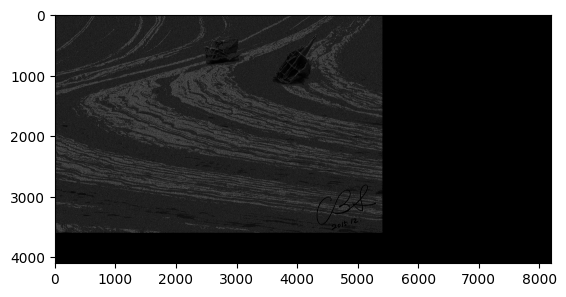

-1.502665256081076e-14 1.502665256081076e-14


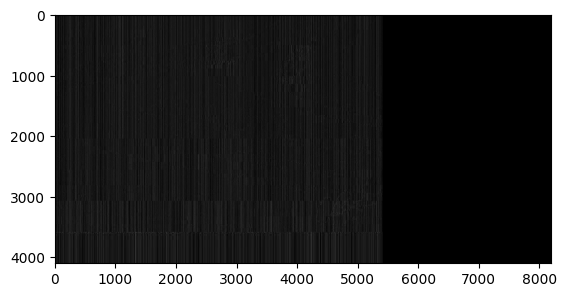

-3.9434076427619023e-31 3.9434076427619023e-31


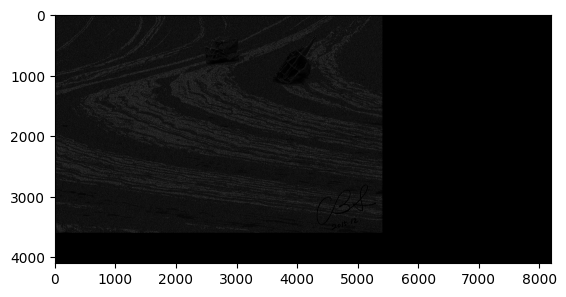

In [ ]:
##second round of compression #compression한것을 한번더 compression

new_img_LL, new_img_LH, new_img_HL, new_img_HH = haar.compress_partial_enc_dec(img_LL)
plt.imshow(rescale(new_img_LL), cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(rescale(new_img_LH), cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(rescale(new_img_HL), cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(rescale(new_img_HH), cmap = "gray", vmin = 0, vmax = 255)
plt.show()


(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096) (2048, 4096) (2048, 4096) (2048, 4096)
(4096, 8192) (4096, 8192) (4096, 8192) (4096, 8192)
(4096, 2048) (4096, 2048) (8192, 4096) (8192, 4096)
(2048, 4096)

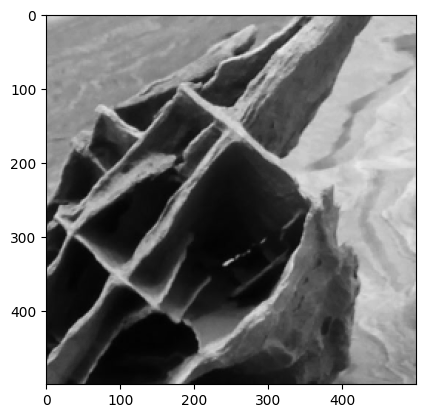

-1.0048529934188276e-14 1.0048529934188276e-14


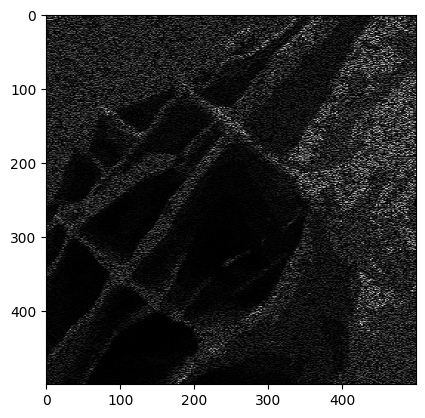

-1.4734836447930303e-14 1.4734836447930303e-14


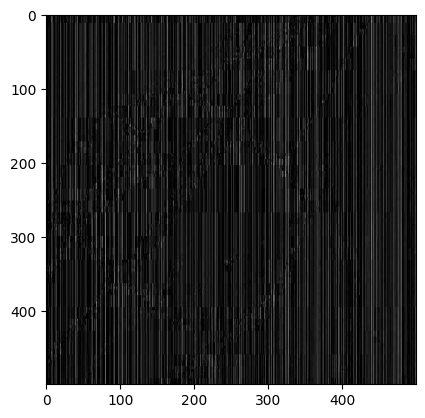

-3.944303105775761e-31 3.944303105775761e-31


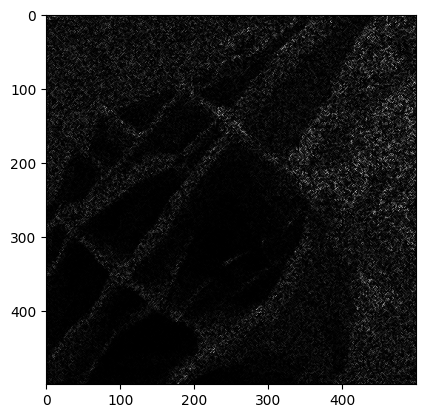

In [ ]:
#auotmate compression up to N times
def compress_multiple(steps, img):
    for i in range(steps):
        img_LL, img_LH, img_HL, img_HH = haar.compress_partial_enc_dec(img)
        img = img_LL
    return img_LL, img_LH, img_HL, img_HH



new_new_img_LL, new_new_img_LH, new_new_img_HL, new_new_img_HH = compress_multiple(32, padded_image)
plt.imshow(rescale(new_new_img_LL)[500:1000,3800:4300], cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(rescale(new_new_img_LH)[500:1000,3800:4300], cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(rescale(new_new_img_HL)[500:1000,3800:4300], cmap = "gray", vmin = 0, vmax = 255)
plt.show()
plt.imshow(rescale(new_new_img_HH)[500:1000,3800:4300], cmap = "gray", vmin = 0, vmax = 255)
plt.show()


## 주의1! 위의것 문제있는 듯.. 왜냐하면, iteratively할때 img shape 이 점점 줄어들어야하는데 그게 아님...
## 또한, 위에서 32번 iteratively 했을때, 1/2^32로 데이터가 줄어들어서 pixelated되어야하는데, 그게 아님!! => 아마도 잘못한듯... 뭔가를 
**iterative compression은 다시해보기!!**(아마도 그 XH_L, XH_H등의 matrix들이 크기자체가 1/2배가아닌 1/2^n 배가 되야할듯...==> 쌤들이랑 논의해보기! )

근데 다른 웹사이트에서 나와야한다는, 가로로만 pixelated, 세로로 pixelated된것은 보이긴 한다 (https://rla020.tistory.com/17)

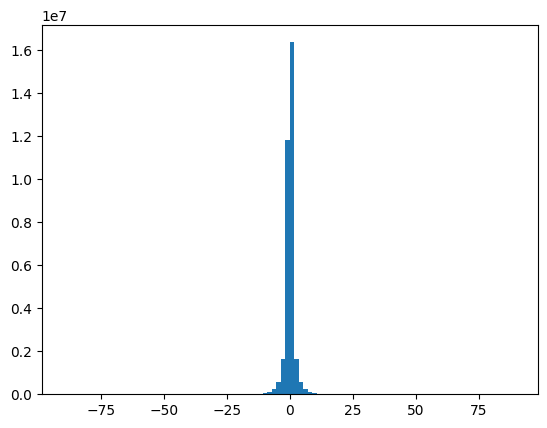

-89.49999999999997 89.49999999999997


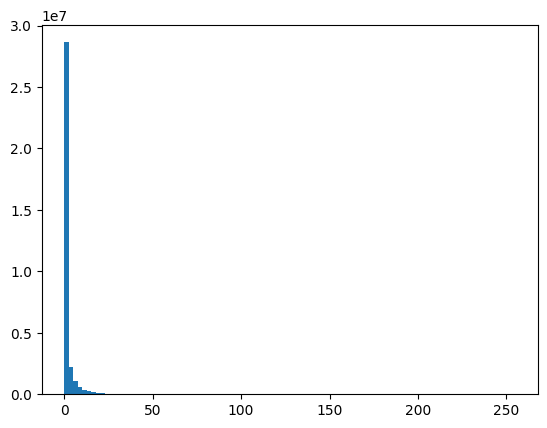

In [ ]:
#보듯이, LH의 distribution이 이상하게 대칭이고, 값들이 모여있다..  => 아마도 뭔가 잘못된듯?
plt.hist(img_LH.flatten(), bins = 100)
plt.show()
plt.hist(rescale(img_LH).flatten(), bins = 100)
plt.show()

(array([1.418311e+07, 1.863500e+04, 1.384500e+04, 1.897800e+04,
        1.467900e+04, 1.470000e+04, 1.212000e+04, 1.257000e+04,
        1.153600e+04, 1.295400e+04, 1.100100e+04, 1.141200e+04,
        9.963000e+03, 1.162400e+04, 9.989000e+03, 1.124700e+04,
        1.087900e+04, 9.369000e+03, 1.116200e+04, 1.029100e+04,
        1.153000e+04, 1.173400e+04, 1.425500e+04, 1.260400e+04,
        1.587900e+04, 1.488400e+04, 1.842100e+04, 1.759100e+04,
        2.409000e+04, 2.354100e+04, 3.391400e+04, 3.415200e+04,
        4.519400e+04, 6.076800e+04, 5.779200e+04, 8.438100e+04,
        8.499900e+04, 1.181940e+05, 1.176870e+05, 1.622820e+05,
        1.600400e+05, 2.041620e+05, 1.899060e+05, 2.451170e+05,
        2.305330e+05, 3.144480e+05, 3.193470e+05, 4.359820e+05,
        4.146660e+05, 4.732590e+05, 5.264600e+05, 4.676580e+05,
        6.130290e+05, 4.924280e+05, 6.050960e+05, 4.563640e+05,
        4.899230e+05, 3.907980e+05, 4.120490e+05, 3.387940e+05,
        3.764660e+05, 3.340150e+05, 3.90

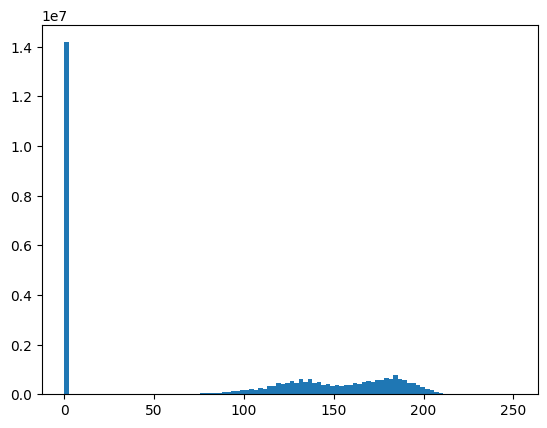

In [ ]:
#이미지 분푸가 0에 많은 이유는 zero padding때문

import matplotlib.pyplot as plt
#plt.hist(img_LL.flatten(), bins = 100)
plt.hist(padded_image.flatten(), bins = 100)

In [ ]:
###TESTING

#test haar matrix creation with n= 8
haar = HaarTransform("./Boneyard_IMG_5341.jpg")

#test haar mat creation
print(haar.get_haar_mat(8))

#test if D_n really normalizes the haar matrix and makes it orthonormal
W = haar.get_haar_mat(8)
H_n = W@haar.D_n(8,3) 
print(H_n.T@H_n)

#getting H_n directly and checking if it returns the same thing
H_n = haar.normalize(haar.get_haar_mat(8))
print(H_n.T@H_n)

[[ 1.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  1.  1.  0. -1. -0. -0. -0.]
 [ 1.  1. -1. -0.  0.  1.  0.  0.]
 [ 1.  1. -1. -0. -0. -1. -0. -0.]
 [ 1. -1.  0.  1.  0.  0.  1.  0.]
 [ 1. -1.  0.  1. -0. -0. -1. -0.]
 [ 1. -1. -0. -1.  0.  0.  0.  1.]
 [ 1. -1. -0. -1. -0. -0. -0. -1.]]
[[ 1.00000000e+00  6.61772052e-17  0.00000000e+00  0.00000000e+00
   2.13321079e-17  2.13321079e-17  2.13321079e-17  2.13321079e-17]
 [ 6.61772052e-17  1.00000000e+00  0.00000000e+00  0.00000000e+00
   2.13321079e-17  2.13321079e-17 -2.13321079e-17 -2.13321079e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.13321079e-17  2.13321079e-17  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.13321079e-17  2.13321079e-17  0.00000000e+00  0.0

#  Haar 로 보낸후 top x%의 값들만 남기고 다시 reconstruction 하기 => 이건 잘됨!

In [45]:
haar = HaarTransform("./Boneyard_IMG_5341.jpg")
power_2_shape = (4096, 8192)
haar.pad(power_2_shape)
padded_image = haar.image_grayscaled
transformed_img = haar.haar_transform_2d(size=power_2_shape, img=padded_image)

compression_percentages = {
    "99%": 1,
    "90%": 10,
    "80%": 20,
    "70%": 30,
    "60%": 40,
    "50%": 50,
    "40%": 60,
    "30%": 70,
    "20%": 80,
    "10%": 90,
    "1%": 99,
    "0.1%": 99.9,
    "0.01%": 99.99,
    "0.001%": 99.999,
    "0.0008%": 99.9992,
    "0.0004%": 99.9996,
    "0.0002%": 99.9998,
    "0.0001%": 99.9999,
    "0.00008%": 99.99992,
    "0.00006%": 99.99994,
    "0.00004%": 99.99996,
    "0.00002%": 99.99998,
    "0.00001%": 99.99999,
    #"0.000001%": 99.99999,
}

reconstructed_images = {}

for percentage, value in compression_percentages.items():
    transformed_img_compressed = haar.compress_matrix(value, transformed_img)
    reconstructed_img = haar.inverse_haar_transform_2d(size=power_2_shape, img_trans=transformed_img_compressed)
    reconstructed_images[percentage] = crop_out_padded_part(reconstructed_img)

cropped_original_image = crop_out_padded_part(padded_image)

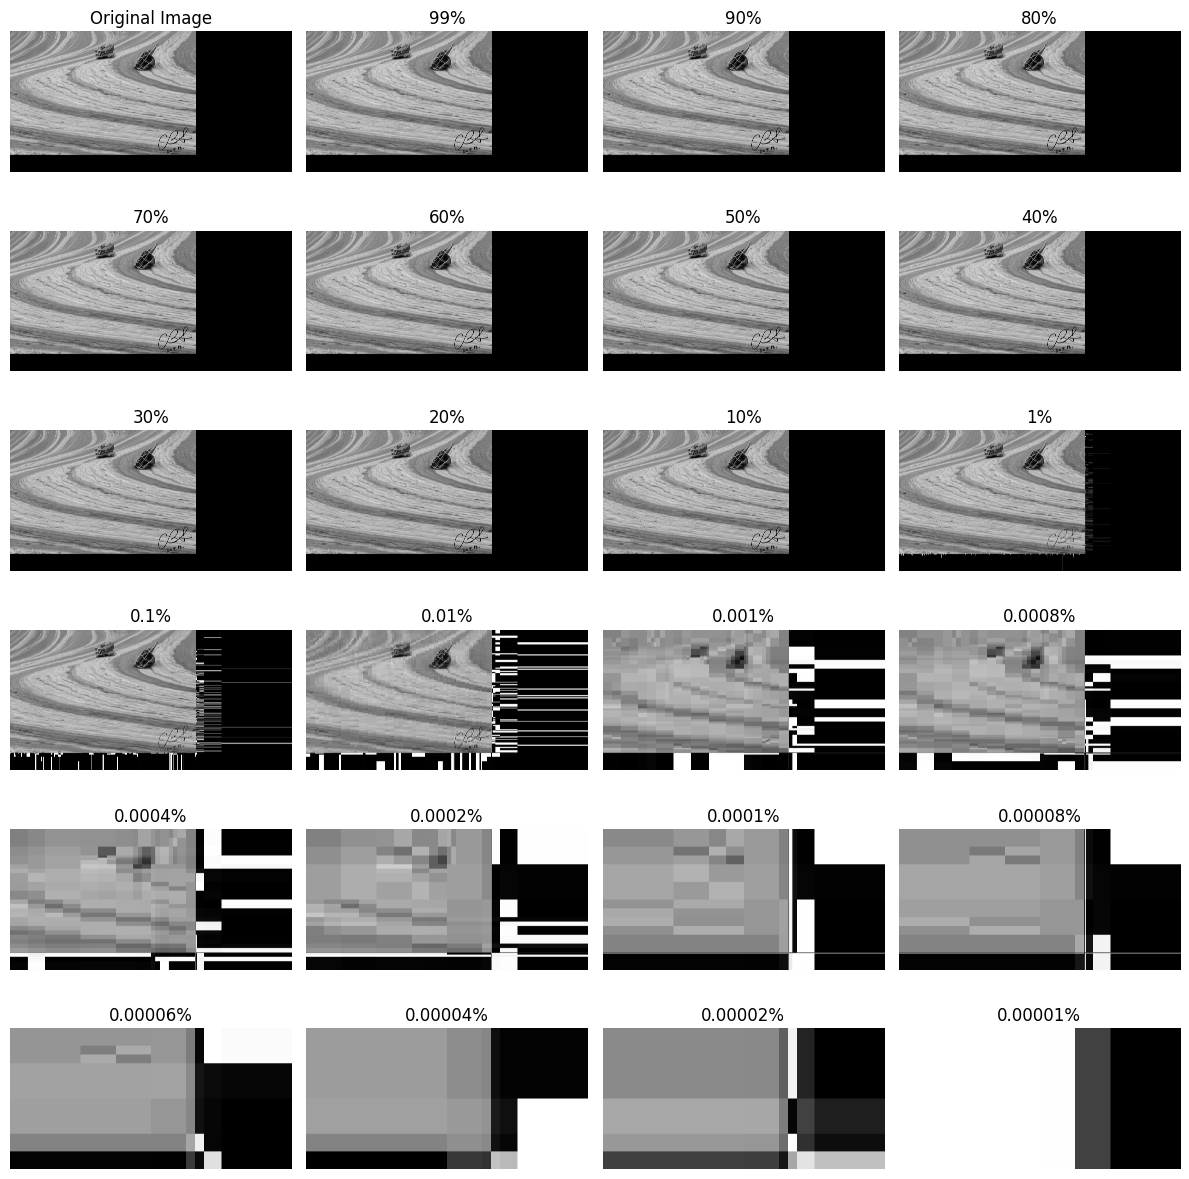

In [46]:
# Create a 6x4 subplot
fig, axs = plt.subplots(6, 4, figsize=(12, 12))

# Plot the original image
axs[0, 0].imshow(cropped_original_image, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# Iterate over the reconstructed_images and plot them in the subplots
for i, (percentage, img) in enumerate(reconstructed_images.items()):
    # Remove the percentage sign from the string
    percentage = percentage.rstrip('%')
    
    row = (i + 1) // 4
    col = (i + 1) % 4
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].set_title(percentage + '%')
    axs[row, col].axis('off')

# Remove empty subplots
for i in range(len(reconstructed_images) + 1, 24):
    row = (i - 1) // 4
    col = (i - 1) % 4
    fig.delaxes(axs[row, col])

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)  # Adjust the hspace parameter to change the space between rows
plt.axis('off')
plt.show()


boundary에서 값이 크게 나와서 artifact인듯?

[0.99, 0.9, 0.8, 0.7000000000000001, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 1e-05, 8.000000000000001e-06, 4.000000000000001e-06, 2.0000000000000003e-06, 1.0000000000000002e-06, 8.000000000000001e-07, 6.000000000000001e-07, 4.0000000000000003e-07, 2.0000000000000002e-07, 1.0000000000000001e-07, 1e-08] [0.0023214273149220264, 0.0023214273149220264, 0.0023214273149220264, 0.0023214273149220264, 0.0023214273149220264, 0.0023214377201077846, 0.0023581285667480275, 0.0025416579430237118, 0.003557840210791148, 0.008456574328934112, 0.037312141246789304, 0.05228655408459112, 0.09539615195889493, 0.09780118842711322, 0.10609187731700084, 0.11582692422958293, 0.12750490762945124, 0.13186681289249375, 0.136929285925454, 0.14227294337848229, 0.15826335587588458, 0.1842692615236502, 0.1842692615236502]


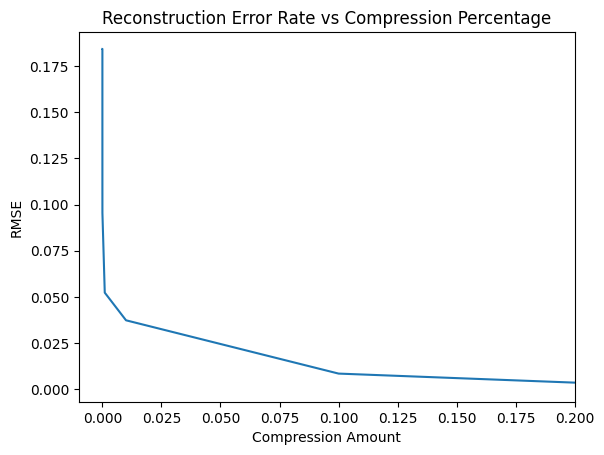

In [35]:
mse = []
x_values = []

for percentage, img in reconstructed_images.items():
    cropped_img = crop_out_padded_part(img)
    mse.append(calculate_rmse(cropped_original_image, cropped_img))
    x_values.append(0.01*float(percentage.rstrip('%')))  # Remove the percentage sign
print(x_values, mse)
plt.plot(x_values, mse)
plt.xlabel("Compression Amount")
plt.ylabel("RMSE")
plt.title("Reconstruction Error Rate vs Compression Percentage")
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-0.01, 0.2)
plt.show()


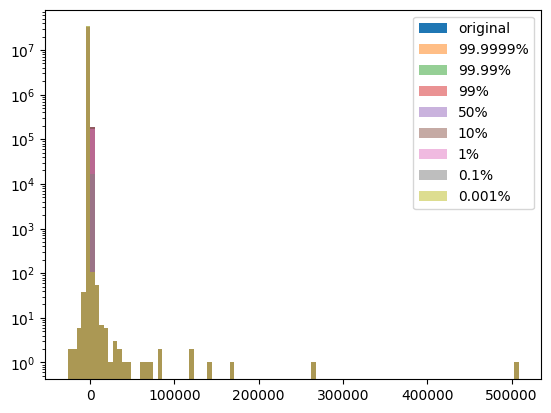

In [ ]:
import matplotlib.pyplot as plt
#draw histogram of the transformed image
plt.hist(transformed_img.flatten(), bins = 100)
plt.yscale('log')
plt.hist(transformed_img_99_9999_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_99_99_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_99_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_50_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_10_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_1_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_01_percent.flatten(), bins = 100, alpha = 0.5)
plt.hist(transformed_img_0001_percent.flatten(), bins = 100, alpha = 0.5)
plt.legend(["original", "99.9999%","99.99%","99%","50%","10%", "1%", "0.1%", "0.001%"])

In [ ]:
haha = [transformed_img, transformed_img_99_99_percent, transformed_img_99_percent, transformed_img_50_percent, transformed_img_10_percent, transformed_img_1_percent, transformed_img_01_percent, transformed_img_0001_percent]
print("shape, min, max, mean, std")
for transformed_img_ in haha:
    print(transformed_img_.shape, transformed_img_.min(), transformed_img_.max(), transformed_img_.mean(), transformed_img_.std(), ((transformed_img_.astype(int)==0.).sum())/transformed_img_.size)

shape, min, max, mean, std


(4096, 8192) -26716.46142578125 508281.0733770991 0.06543970049799752 118.40924341644592 0.7199591100215912
(4096, 8192) -26716.46142578125 508281.0733770991 0.06543970049799752 118.40924341644592 0.7199591100215912
(4096, 8192) -26716.46142578125 508281.0733770991 0.06543970049799752 118.40924341644592 0.7199591100215912
(4096, 8192) -26716.46142578125 508281.0733770991 0.06543970049799754 118.40924341644592 0.7199591100215912
(4096, 8192) -26716.46142578125 508281.0733770991 0.060948988956802314 118.40474441522653 0.9001308381557465
(4096, 8192) -26716.46142578125 508281.0733770991 0.053748446204404256 118.33755931081078 0.9900000989437103
(4096, 8192) -26716.46142578125 508281.0733770991 0.0575645075542487 118.1031557916865 0.9989999830722809
(4096, 8192) -26716.46142578125 508281.0733770991 0.06414339436684426 116.93401728002398 0.9999899864196777


0.24371543526649475
[]


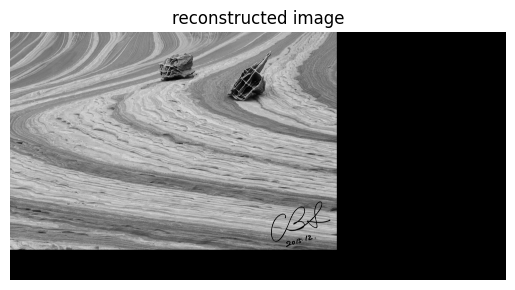

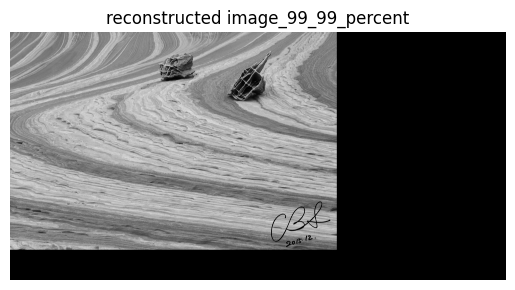

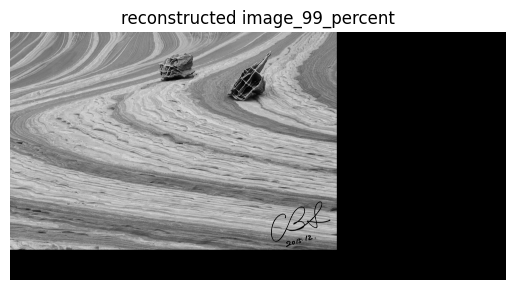

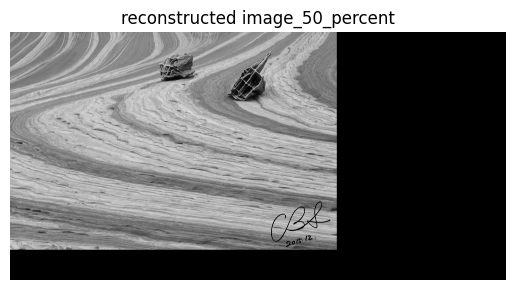

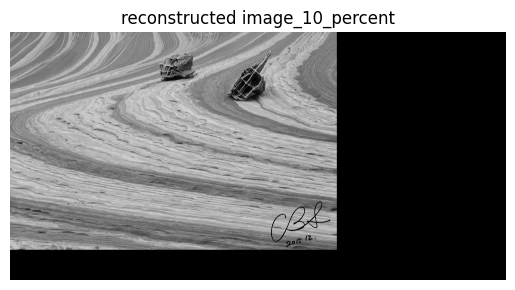

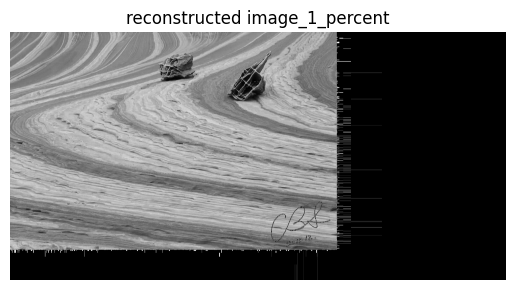

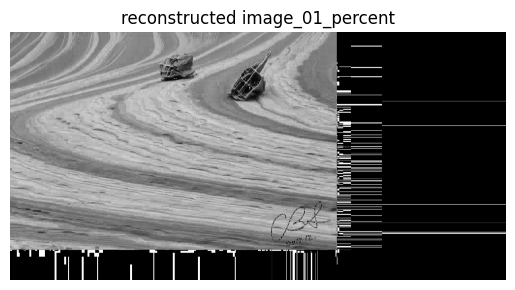

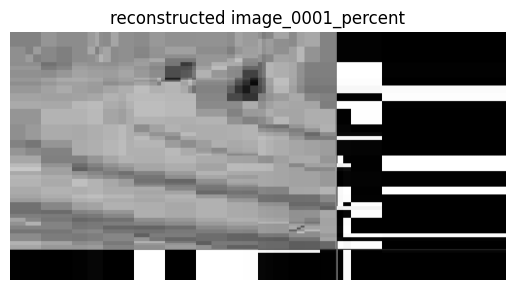

In [ ]:
##보듯이, 거의 0.01%까지 compression되어도 살아있다..ㅋㅋㅋ
print(np.sum(transformed_img==haar.image_grayscaled)/transformed_img.size) #exact match percentage
print(np.sum(transformed_img-haar.image_grayscaled)**2/()) #exact match count
utils.imshow(reconstructed_img, "reconstructed image", True)
utils.imshow(reconstructed_img_99_99_percent, "reconstructed image_99_99_percent", True)
utils.imshow(reconstructed_img_99_percent, "reconstructed image_99_percent", True)
utils.imshow(reconstructed_img_50_percent, "reconstructed image_50_percent", True)
utils.imshow(reconstructed_img_10_percent, "reconstructed image_10_percent", True)
utils.imshow(reconstructed_img_1_percent, "reconstructed image_1_percent", True)
utils.imshow(reconstructed_img_01_percent, "reconstructed image_01_percent", True)
utils.imshow(reconstructed_img_0001_percent, "reconstructed image_0001_percent", True)

In [ ]:
print(padded_image.shape, padded_image.min(), padded_image.max())

(4096, 8192) 0.0 251.0
